# Win/Loss Prediction

In [29]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the CSV data into a DataFrame
data = pd.read_csv('win_loss.csv')

# Separate features (X) and target (y)
X = data.drop(columns=['win', 'match_id'])
y = data['win']

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [30]:
# Specify categorical columns (if any)
categorical_cols = ['enemies_0', 'enemies_1', 'enemies_2', 'enemies_3',
       'enemies_4', 'teammates_0', 'teammates_1', 'teammates_2', 'teammates_3',
       'teammates_4']  # Add the names of categorical columns here

# Create an XGBoost DMatrix with categorical feature support
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=categorical_cols)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=categorical_cols)

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',  # You can use other metrics as well
    'eta': 0.1,  # Learning rate
    'max_depth': 6,  # Max depth of the tree
    'min_child_weight': 1,  # Minimum sum of instance weight (hessian)
    'gamma': 0,  # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': 0.8,  # Fraction of samples used for training
    'colsample_bytree': 0.8,  # Fraction of features used for training
    'nthread': -1,  # Use all available CPU threads
    'random_state': 42
}

# Train the XGBoost classifier
num_round = 30  # You can adjust this based on your dataset
bst = xgb.train(params, dtrain, num_round, [(dtest,'eval'), (dtrain,'train')])

[0]	eval-logloss:0.69800	train-logloss:0.67120
[1]	eval-logloss:0.70157	train-logloss:0.65386
[2]	eval-logloss:0.70118	train-logloss:0.63658
[3]	eval-logloss:0.70658	train-logloss:0.62007
[4]	eval-logloss:0.71158	train-logloss:0.60361
[5]	eval-logloss:0.71776	train-logloss:0.59111
[6]	eval-logloss:0.71573	train-logloss:0.58004
[7]	eval-logloss:0.71260	train-logloss:0.56700
[8]	eval-logloss:0.71931	train-logloss:0.55197
[9]	eval-logloss:0.72065	train-logloss:0.54025
[10]	eval-logloss:0.73127	train-logloss:0.52801
[11]	eval-logloss:0.73607	train-logloss:0.52148
[12]	eval-logloss:0.74470	train-logloss:0.51258
[13]	eval-logloss:0.74752	train-logloss:0.49994
[14]	eval-logloss:0.74476	train-logloss:0.49150
[15]	eval-logloss:0.74910	train-logloss:0.48399
[16]	eval-logloss:0.74979	train-logloss:0.47522
[17]	eval-logloss:0.75275	train-logloss:0.46522
[18]	eval-logloss:0.75055	train-logloss:0.45900
[19]	eval-logloss:0.75277	train-logloss:0.45298
[20]	eval-logloss:0.75466	train-logloss:0.44389
[2

/Users/jm/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [31]:
# Make predictions on the test set
y_pred = bst.predict(dtest)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 46.00%


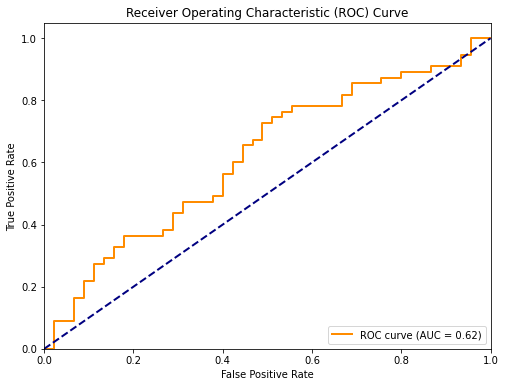

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Get predicted probabilities for the positive class (class 1)
y_pred_prob = -bst.predict(dtest)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# MCTS

In [33]:
"""
A minimal implementation of Monte Carlo tree search (MCTS) in Python 3
Luke Harold Miles, July 2019, Public Domain Dedication
See also https://en.wikipedia.org/wiki/Monte_Carlo_tree_search
https://gist.github.com/qpwo/c538c6f73727e254fdc7fab81024f6e1
"""
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import random

heroes_set = {i for i in range(5)}
max_plays = 4
ban_turns = [0,1]
def probability_pick(depth, hero):
    return hero/(1+depth*60)
def model_win_rate(predecessors):
    return 0.5


class MCTS:
    "Monte Carlo tree searcher. First rollout the tree then choose a move."

    def __init__(self, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.exploration_weight = exploration_weight

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            print(node.__hash__())
            if node not in self.children or node.is_terminal(): # is terminal only when the algo finishes
                return path
            print('children', set(self.children[node]))
            print('keys: ', set(self.children.keys()))
            unexplored = set(self.children[node]) - set(self.children.keys())
            print('unexplored', unexplored)
            if unexplored:
                n = unexplored.pop()
                path.append(n)
                return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        self.children[node] = node.find_children()

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        while True:
            if node.is_terminal():
                return node.reward()
            node = node.find_random_child()

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward
            reward = -reward  # 1 for me is 0 for my enemy, and vice versa

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        log_N_vertex = math.log(self.N[node])

        def uct(n):
            "Upper confidence bound for trees"
            return self.Q[n] / self.N[n] + self.exploration_weight * math.sqrt(
                log_N_vertex / self.N[n]
            )

        return max(self.children[node], key=uct)


class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """
    
    def __init__(self, predecessors=set()):
        self.predecessors=predecessors
        self.depth=len(predecessors)

    def find_children(self):
        "All possible successors of this board state"
        children = []
        for state in heroes_set.difference(self.predecessors):
            child_preds = self.predecessors.copy()
            child_preds.add(state)
            children.append(Node(child_preds))
        return children

    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        state = random.choice( list(heroes_set.difference(self.predecessors)) )
        child_preds = self.predecessors.copy()
        child_preds.add(state)
        return Node(child_preds)

    def is_terminal(self):
        "Returns True if the node has no children"
        return self.depth==max_plays-1

    def reward(self):
        "Assumes `self` is terminal node. 1=win, 0=loss, .5=tie, etc"
        prob=1
        for (i, state) in enumerate(self.predecessors):
            prob *= probability_pick(i, state)
        return prob*model_win_rate(self.predecessors)

    def __hash__(self):
        "Nodes must be hashable"
        if self.predecessors == set():
            return -1
        return int(''.join(map(str, self.predecessors)))

    def __eq__(node1, node2):
        "Nodes must be comparable"
        return node1.__hash__() == node2.__hash__()
    
    def __str__(self):
        if self.predecessors == set():
            return str(-1)
        return ''.join(map(str, self.predecessors))


In [34]:
node0 = Node()

mcts=MCTS()

mcts.do_rollout(node0)
print(mcts.Q.values())

In [ ]:
for i in range(100000):
    mcts.do_rollout(node0)

In [37]:
len(mcts.children.values())

1

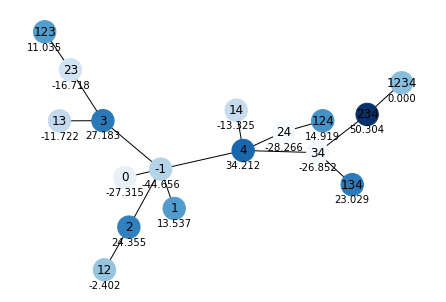

In [75]:
import networkx as nx
import matplotlib.pyplot as plt

# Build the tree
G = nx.Graph()
stack = [(None, node0)]  # (parent, current_node)
visited = set()  # To keep track of visited nodes
while stack:
    parent, node = stack.pop()
    if node not in visited:
        visited.add(node)
        if parent is not None:
            G.add_edge(parent, node)
        if node in mcts.children:
            for child in mcts.children[node]:
                stack.append((node, child))
node_values = { n: mcts.Q[n]/(1+mcts.N[n]) for n in mcts.Q.keys()}

# Graphics
pos = nx.spring_layout(G)  # Define the layout of the tree
#pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
node_colors = [node_values[node] for node in G.nodes]

# Modify the labels dictionary to display only the first few digits (e.g., 3 digits)
labels = {node: f"{mcts.Q[node]:.3f}" for node in G.nodes}

# Adjust vertical positions of nodes
label_pos = {k: (x, y - 0.05) for k, (x, y) in pos.items()}

# Draw the nodes and edges
nx.draw(G, pos, with_labels=True, node_color=node_colors, cmap=plt.cm.Blues, node_size=500)
labels = {node: f"{mcts.Q[node]:.3f}" for node in G.nodes}
nx.draw_networkx_labels(G, label_pos, labels=labels, font_size=10, verticalalignment="top")

# Show the plot
plt.show()



In [392]:
!python -m pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
!arch -arm64 brew install graphviz

In [406]:
!pip uninstall pygraphviz -y

Found existing installation: pygraphviz 1.11
Uninstalling pygraphviz-1.11:
  Successfully uninstalled pygraphviz-1.11


In [23]:
!pip install pygraphviz

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [55]:
1e-3

0.001